# Task 2 Finetune MHIST Dataset

In [1]:
# Download and untar Dataset
!wget https://cloud.uol.de/s/CQkXGQd6prLW8xc/download/MHIST.tar.gz
!mkdir mhist
!tar -xf MHIST.tar.gz -C mhist/

--2023-01-29 17:15:22--  https://cloud.uol.de/s/CQkXGQd6prLW8xc/download/MHIST.tar.gz
Resolving cloud.uol.de (cloud.uol.de)... 134.106.87.50, 2001:638:705:3f15::50
Connecting to cloud.uol.de (cloud.uol.de)|134.106.87.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345780687 (330M) [application/x-gzip]
Saving to: ‘MHIST.tar.gz’

MHIST.tar.gz        100%[===================>] 329.76M  17.2MB/s    in 21s     

2023-01-29 17:15:45 (15.5 MB/s) - ‘MHIST.tar.gz’ saved [345780687/345780687]



## Create a dataset and inspect it a little bit

In [2]:
import torch
import torchvision
from PIL import Image, ImageDraw, ImageFont    
from typing import Tuple
from pathlib import Path
import pandas as pd
from transformers import ViTFeatureExtractor, ViTForImageClassification



id2label = {0: "HP", 1: "SSA"}
label2id = {"HP" : 0, "SSA": 1}

class MHISTDataset(torch.utils.data.Dataset):
    
    def __init__(self, path: Path, annotations: pd.DataFrame, extractor) -> None:
        super().__init__()
        
        self.images = []
        self.labels = []
        for i, (image_name, m_annotation, _, _) in annotations.iterrows():
            self.images.append(Image.open(path / image_name))
            self.labels.append(label2id[m_annotation])
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx:int):
        inputs = extractor(self.images[idx], return_tensors="pt")
        inputs["labels"] = self.labels[idx]
        return inputs

In [3]:
# load annotations file
from pathlib import Path
import pandas as pd

extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

extractor_two = ViTFeatureExtractor.from_pretrained("facebook/dino-vitb16")

annotations = Path("./mhist/annotations.csv")
images = Path("./mhist/images/")

df = pd.read_csv(annotations)
train_annotations = df[df.Partition.eq("train")]
test_annotations = df[df.Partition.eq("test")]

ds_train_one = MHISTDataset(images, train_annotations, extractor)
ds_test_one = MHISTDataset(images, test_annotations, extractor)

ds_train_two = MHISTDataset(images, train_annotations, extractor_two)
ds_test_two = MHISTDataset(images, test_annotations, extractor_two)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

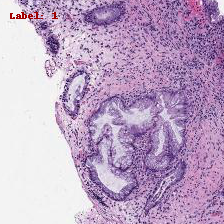

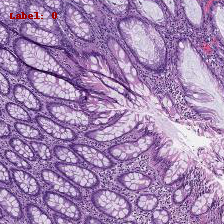

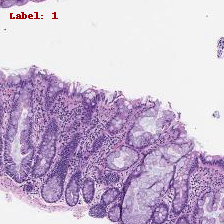

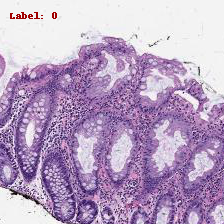

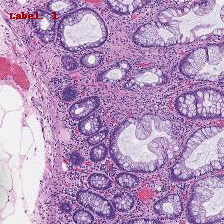

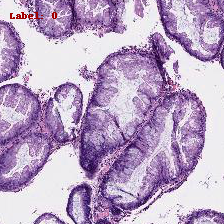

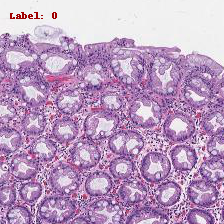

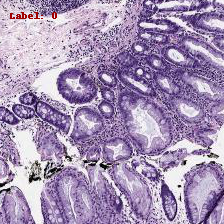

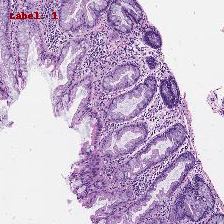

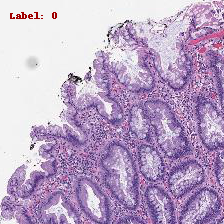

In [4]:
# display some images 
def plot_image_from_ds(image, label):
    draw = ImageDraw.Draw(image)
    draw.text( (10,10), f"Label: {label}", fill="#a00000")
    display(image)
              
for i in range(10):
    plot_image_from_ds(ds_train_one.images[i], ds_train_one.labels[i])

In [5]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)

model_two = ViTForImageClassification.from_pretrained(
    "facebook/dino-vitb16",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)


Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/454 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def collate_fn(batch):
    r = {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch], dim=1).squeeze(0),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
    return r

In [7]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=64,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    push_to_hub=False,
    report_to='tensorboard',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=ds_train_one,
    compute_metrics=compute_metrics,
    tokenizer=extractor,
    data_collator=collate_fn,
)

In [8]:
metrics_train_one = trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2175
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 102


Step,Training Loss
10,0.563000
20,0.446100
30,0.378100
40,0.287300
50,0.228800
60,0.234000
70,0.215700
80,0.149900
90,0.131000
100,0.118900




Training completed. Do not forget to share your model on huggingface.co/models =)




In [9]:
metrics_model_one = trainer.evaluate(ds_test_one)

***** Running Evaluation *****
  Num examples = 977
  Batch size = 8


In [10]:
trainer_two = Trainer(
    model=model_two,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=ds_train_two,
    compute_metrics=compute_metrics,
    tokenizer=extractor,
    data_collator=collate_fn,
)

In [11]:
metrics_train_two = trainer_two.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2175
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 102


Step,Training Loss
10,1.795200
20,0.598100
30,0.425000
40,0.350000
50,0.238700
60,0.201900
70,0.203500
80,0.113800
90,0.064200
100,0.052600




Training completed. Do not forget to share your model on huggingface.co/models =)




In [12]:
metrics_model_two = trainer_two.evaluate(ds_test_two)

***** Running Evaluation *****
  Num examples = 977
  Batch size = 8


## Compare Training Metrics

In [13]:
print(metrics_train_one)
print(metrics_train_two)

TrainOutput(global_step=102, training_loss=0.2709835405443229, metrics={'train_runtime': 136.8767, 'train_samples_per_second': 47.671, 'train_steps_per_second': 0.745, 'total_flos': 5.056352322352128e+17, 'train_loss': 0.2709835405443229, 'epoch': 3.0})
TrainOutput(global_step=102, training_loss=0.39695240374581486, metrics={'train_runtime': 131.494, 'train_samples_per_second': 49.622, 'train_steps_per_second': 0.776, 'total_flos': 5.056352322352128e+17, 'train_loss': 0.39695240374581486, 'epoch': 3.0})


## Compare Eval Metrics

In [14]:
print(metrics_model_one)
print(metrics_model_two)

{'eval_loss': 0.3814835250377655, 'eval_accuracy': 0.8444216990788127, 'eval_runtime': 10.4915, 'eval_samples_per_second': 93.123, 'eval_steps_per_second': 11.724, 'epoch': 3.0}
{'eval_loss': 0.39628866314888, 'eval_accuracy': 0.8546571136131014, 'eval_runtime': 10.3706, 'eval_samples_per_second': 94.208, 'eval_steps_per_second': 11.86, 'epoch': 3.0}
